In [1]:
# 뉴스 요약봇 만들기

## 모듈 추가 및 NLTK 패키지 불용어 사전 다운로드
import nltk
nltk.download('stopwords')

# 데이터 전처리 for문에서 진행 바 보고싶어서 추가
from tqdm import tqdm

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 총 568,454 샘플 중 100,000개 샘플만 뽑기
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [3]:
# head() 확인
data.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [4]:
# 데이터프레임 data에 `Text`, 'Summary' 컬럼만 남기기
# 랜덤 (15개) 샘플 출력까지

# Input [[YOUR CODE]] aside `data`
data = data[['Text', 'Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

Text  \
83882  There's really not a ton to say; they're whole...   
26463  I have to say that Buffalo Bills has really im...   
66392  Purchased this to use for travel as it's diffi...   
80510  Please eat Organic Grass Fed Liver products. T...   
22739  The shortbread arrived well packaged and intac...   
70123  As far as dry iced tea mixes go, this is a ver...   
49991  Raw Revolution Organic Live Food Bars, Coconut...   
83185  Had my big noble boy dog, who had been with me...   
9990   Great product, our daughter loves this and has...   
93983  My dog is not enthusiastic about food.  She en...   
81710  I am a brazilian living in the US and drank Vi...   
99314  I hate to give a bad review since I have no id...   
39192  My dogs love the food. Good value for no grain...   
54174  I would buy more but I eat like 20 of them in ...   
42015  I have been having the Quaker Weight Control M...   

                                                 Summary  
83882                                               Nice  
26463                          Buffalo Bills is the BEST  
66392                 Metallic Taste is the Deal Breaker  
80510                          If You're Gonna Liver....  
22739                              Arrived well packaged  
70123                               Very average product  
49991                                         Taste Good  
83185  Consistently in the top ten recommended canned...  
9990                            Baby loves, and so do we  
93983                                       Liver treats  
81710                         Always great coconut water  
99314  WARNING--DO NOT USE IF YOU ARE ALLERGIC TO PEA...  
39192                 Nature's Variety Instinct dog food  
54174                                    Love this candy  
42015                                  But Where's Mine?

In [5]:
# 데이터 중복 샘플 유무 확인
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())
    

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [6]:
# 데이터 중복 샘플 제거
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


In [7]:
# 데이터프레임 null값 확인
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [8]:
# 데이터프레임 null값 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


In [9]:
# 텍스트 정규화를 위한 사전(dictionary) 구성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
# 불용어 개수 및 내역 파악
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [12]:
# 데이터전처리 함수 검증
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [13]:
# 전처리한 파일(CSV)가 없으면 아래를 수행하게끔
if os.path.isfile('preprocessed_data.csv') == False:
    # 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
    clean_text = []

    # [[YOUR CODE]]
    for sentence in tqdm(data['Text'], desc="Text 컬럼 전처리.."):
        clean_text.append(preprocess_sentence(sentence, remove_stopwords=True))

    # 전처리 한 데이터 길이 보자
    print(f"Length of the `clean_text`: {len(clean_text)}")

    # 전처리 후 출력
    print("Text 전처리 후 결과: ", clean_text[:5])
    
    # 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
    clean_summary = []

    # [[YOUR CODE]]
    for sentence in tqdm(data['Summary'], desc="Summary 컬럼 전처리.."):
        clean_summary.append(preprocess_sentence(sentence, remove_stopwords=False))

    # 전처리 한 데이터 길이 보자
    print(f"Length of the `clean_summary`: {len(clean_summary)}")

    print("Summary 전처리 후 결과: ", clean_summary[:5])
    
    # 데이터를 DataFrame에 저장
    data['Text'] = clean_text
    data['Summary'] = clean_summary

    # 빈 값을 Null 값으로 변환
    data.replace('', np.nan, inplace=True)
    print('=3')
    
    # Null 값 여부 체크
    data.isnull().sum()
    
    # Null 값 제거 후, 전체 샘플 수 확인
    data.dropna(axis=0, inplace=True)
    print('전체 샘플수 :', (len(data)))
    
    ## preprocessing된 DataFrame을 CSV로 백업
    ## 이후 커널을 새로 돌리거나 한다면 전처리과정을 이 파일로 퉁 치자
    data.to_csv('preprocessed_data.csv')
    print("CSV 백업완료")
else:
    # 파일 만들어뒀으면 data는 그냥 이거로 퉁
    data = pd.read_csv(os.getenv("HOME")+"/aiffel/preprocessed_data.csv")
    print("CSV read 완료!")
    

CSV read 완료!


텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


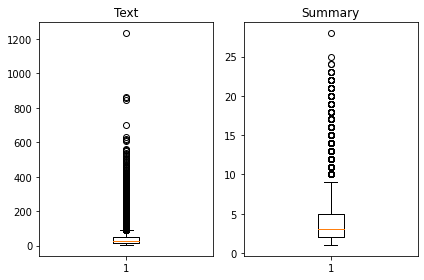

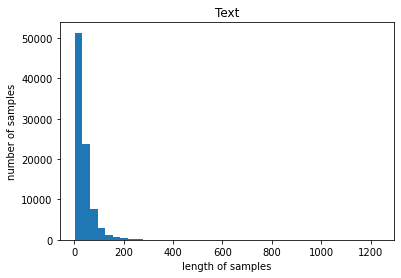

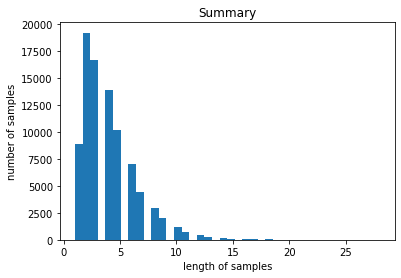

In [14]:
# Text와 Summary 최소, 최대, 평균 길이 구하기
# 길이 분포 시각화 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
# Text, Summary 최대 길이 임의 세팅
text_max_len = 50
summary_max_len = 8
print('=3')

=3


In [16]:
# 데이터 비율 (최대길이 설정값 이하인 데이터들이 얼마나 있는지를 비율로 표시)
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [17]:
# 비율 확인
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [18]:
# [[YOUR CODE]]
## 모든 구현은 apply()와 lambda 식을 사용

# data['Text'] 데이터 중에서 text_max_len = 50 길이보다 큰 샘플은 제외하기
## df.apply()는 Series를 반환
### df.apply()로 획득한 값은 데이터프레임의 특정 컬럼에 들어가야 값이 변경(update)됨
#### 50 길이보다 길면 None (Null 값)이 들어감
data['Text'] = data['Text'].apply(lambda x:x if len(x.split()) <= text_max_len else None)

# data['Summary'] 데이터 중에서 summary_max_len = 8 길이보다 큰 샘플은 제외하기
## df.apply()는 Series를 반환
### df.apply()로 획득한 값은 데이터프레임의 특정 컬럼에 들어가야 값이 변경(update)됨
data['Summary'] = data['Summary'].apply(lambda x:x if len(x.split()) <= summary_max_len else None)

# Null 값 여부 체크
data.isnull().sum()

# 모든 열의 Null 값 제거
data.dropna(axis=0, inplace=True)

# 이전이랑 같은거 같다?..
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


In [19]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

Unnamed: 0                                               Text  \
0           0  bought several vitality canned dog food produc...   
1           1  product arrived labeled jumbo salted peanuts p...   
2           2  confection around centuries light pillowy citr...   
3           3  looking secret ingredient robitussin believe f...   
4           4  great taffy great price wide assortment yummy ...   

                 Summary                   decoder_input  \
0  good quality dog food  sostoken good quality dog food   
1      not as advertised      sostoken not as advertised   
2    delight says it all    sostoken delight says it all   
3         cough medicine         sostoken cough medicine   
4            great taffy            sostoken great taffy   

                   decoder_target  
0  good quality dog food eostoken  
1      not as advertised eostoken  
2    delight says it all eostoken  
3         cough medicine eostoken  
4            great taffy eostoken

In [20]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [21]:
# 훈련 데이터와 테스트 데이터 분리
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[17399 36030 36963 ... 39496 10332 58069]


In [22]:
# 정수 시퀀스를 이용해 다시 데이터 샘플 순서 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [23]:
# 섞인 데이터를 8:2 비율로 분리 (train_set : test_set = 8:2)
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13163


In [24]:
# 정의한 테스트 데이터 개수
# 이용하여 전체 데이터 양분
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

## 노드기준 다음 값이 나와야 한다.
## 훈련 데이터 : 52,655개
## 테스트 데이터 13,163개

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


In [25]:
# Keras 토크나이저 사용
## 입력된 훈련 데이터로부터 단어 집합 만들기
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [26]:
# 빈도수 낮은 단어들 제외하기
## 7회 미만인 단어들은 훈련하지 않음(훈련데이터에서 제외처리)
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31927
등장 빈도가 6번 이하인 희귀 단어의 수: 23695
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8232
단어 집합에서 희귀 단어의 비율: 74.2161806621355
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3893270042992043


In [27]:
# 위에서 단어집합의 크기가 8x00개 정도 나와서
## src_vocab을 8,000으로 세팅
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [28]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[6, 2410, 235, 459, 114, 340, 1508, 283, 2410, 9, 115, 1814, 1145, 167, 90, 196, 23, 96, 410, 137, 88, 56, 964, 177, 91, 98, 319, 281, 354, 205, 35, 26, 4905, 7, 46, 116, 3971, 114, 186, 257, 21, 996], [61, 21, 600, 231, 19, 43, 1, 669, 159, 194, 3972, 4068, 564, 1959, 3193, 600, 19, 7, 101, 2437, 21, 600, 91, 453, 17], [50, 373, 1401, 196, 277, 183, 1, 347, 3298, 2295, 31, 174, 31, 4621, 4757, 1349, 1019, 38, 131, 3398, 2411]]


In [29]:
# Summary 데이터도 다음을 수행
## Keras의 토크나이저 사용해서 decoder_input_train을 입력으로
## 전체 단어 집합과 각 단어에 대한 빈도수 계산
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [30]:
# 등장 빈도수가 6회 미만인 단어들의 비중 확인
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10504
등장 빈도가 5번 이하인 희귀 단어의 수: 8118
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2386
단어 집합에서 희귀 단어의 비율: 77.28484386900229
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.890030929877917


In [31]:
# 희귀 단어 제외시킬 경우의 단어 집합 크기가 2300~2400정도니
## 제거할 단어 크기 2000으로 설정
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 28, 45, 16], [1, 61, 237, 25, 35], [1, 12, 110, 6, 141, 28], [1, 1155, 629], [1, 3, 14, 191, 259, 56, 118]]
target
decoder  [[28, 45, 16, 2], [61, 237, 25, 35, 2], [12, 110, 6, 141, 28, 2], [1155, 629, 2], [3, 14, 191, 259, 56, 118, 2]]


In [32]:
# 빈 데이터들을 추출; 실제 길이는 1
## drop_train, drop_test에 각각 저장
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1256
삭제할 테스트 데이터의 개수 : 362
훈련 데이터의 개수 : 51399
훈련 레이블의 개수 : 51399
테스트 데이터의 개수 : 12801
테스트 레이블의 개수 : 12801


In [33]:
# 서로 다른 길이의 샘플들을 병렬 처리
## Padding 작업 수행
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


In [34]:
# 모델 설계하기
# 함수형 API 이용 (LSTM 1, 2, 3)
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Warning 메시지 무시하기
import warnings
warnings.filterwarnings('ignore')


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# [[YOUR CODE]]
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# [[YOUR CODE]]
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [35]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [36]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [37]:
## 어텐션 메커니즘을 수행하는 함수 추가
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [38]:
# 설계한 모델로 훈련하기
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
201/201 [==============================] - 152s 696ms/step - loss: 2.7008 - val_loss: 2.4249
Epoch 2/50
201/201 [==============================] - 139s 692ms/step - loss: 2.3642 - val_loss: 2.2777
Epoch 3/50
201/201 [==============================] - 139s 691ms/step - loss: 2.2100 - val_loss: 2.1589
Epoch 4/50
201/201 [==============================] - 138s 684ms/step - loss: 2.1023 - val_loss: 2.0761
Epoch 5/50
201/201 [==============================] - 139s 693ms/step - loss: 2.0205 - val_loss: 2.0205
Epoch 6/50
201/201 [==============================] - 139s 694ms/step - loss: 1.9571 - val_loss: 1.9822
Epoch 7/50
201/201 [==============================] - 136s 678ms/step - loss: 1.9034 - val_loss: 1.9518
Epoch 8/50
201/201 [==============================] - 134s 667ms/step - loss: 1.8597 - val_loss: 1.9267
Epoch 9/50
201/201 [==============================] - 96s 478ms/step - loss: 1.8193 - val_loss: 1.9108
Epoch 10/50
201/201 [==============================] - 96s 477ms/

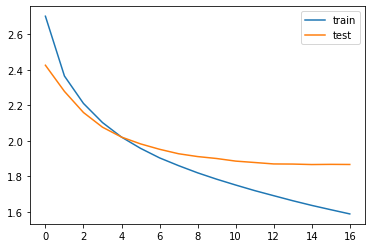

In [39]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [40]:
# 테스트 단계
## 정수 인덱스 행렬이던 텍스트 데이터를 실제 데이터로 복원해야함
# 필요한 3개의 사전 준비
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [41]:
# 정답이 없는 인퍼런스 모델에서는 별도 모델을 설계해야함
## 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야하기 때문
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [42]:
## 어텐션 메커니즘을 사용하는 출력층
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [43]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


In [44]:
# seq2text 함수처럼 요약문이 정수 시퀀스를 텍스트로 변환하는 seq2summary 함수 코드
## 작성 (Hint. 요약문에는 sostoken, eostoken을 고려해야함)\
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    # [[YOUR CODE]]
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [45]:
# 테스트 데이터 약 50개 샘플
## 실제 요약과 예측된 요약을 비교하시오
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : nd purchase amazon im disappointed receive package oatmeal squares indicate best buy date least two boxes date 
실제 요약 : months to expiration 
예측 요약 :  not as good as the


원문 : wheat free bread mix better expected bread moist tasty makes pie crust 
실제 요약 : moist and tasty 
예측 요약 :  pamela bread mix


원문 : enjoyed cereal long remember found difficult find tried brands terrible thrilled find reliable source product amazon 
실제 요약 : the only true raisin bran 
예측 요약 :  great product


원문 : purchased ounce containers flavored salt september paying ship worth merchandise still waiting people seem interested customer service 
실제 요약 : still waiting 
예측 요약 :  not what ordered


원문 : robust roast definitely morning coffee love flavor value sure store airtight container maintain flavor 
실제 요약 : robust and 
예측 요약 :  good coffee


원문 : coffee become one daily favorites quite strong many french roasts also bitter good way start day 
실제 요약 : good daily roast 
예측 요약 :  great coffee


원문 : caution 

In [46]:
# 매트릭스 시놉시스 데이터 다운로드
import requests
from summa.summarizer import summarize

text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [47]:
# 매트릭스 시놉세스 데이터 일부 출력
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [48]:
# Summa summarize()의 args
# text(str) : 요약할 텍스트
# words (int or None, optional) : 출력에 포함할 단어 수
# 만약 ratio와 함께 위 두 파라미터가 모두 제공되면, ratio는 무시함
# split(bool, optional) - True일 경우, 문장 list, False일 경우 join된 문자열을 반환

# 원문의 0.005%만을 요약해서 출력
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [49]:
# 요약결과를 list로 받고 싶은 경우
# split 인자의 값을 True로
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [50]:
# 단어 수로 요약문 크기 조절
# 50개 단어만 선택하는 예시
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
